### This notebook demonstrates how to run a simple visibility simulation with 20 random point sources and an airy beam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from VisPB import Sky_Model, Beam_Model, Vis_Simulator

### Setting up the antenna configuration

Antenna configuration should be set up in a dictionary form for the visibility simulation

In [2]:
antenna_config = {0: [0., 0., 0.],
                  1: [14.6, 0. , 0.],
                  2: [-7.3, 12.64, 0.],
                  3: [7.3, 12.64, 0.],
                  4: [21.9, 12.64, 0.],
                  5: [0., 25.29, 0.],
                  6: [14.6, 25.29, 0.]}
ants = list(antenna_config.keys())

(-5.0, 30.29)

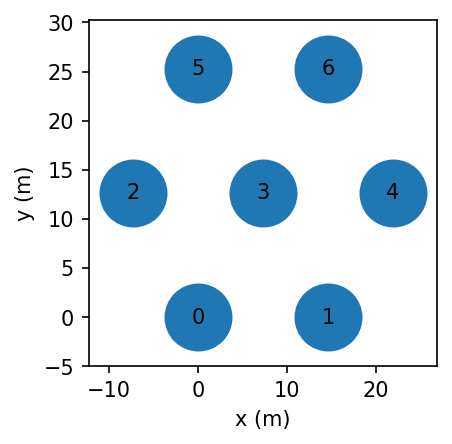

In [3]:
ant_pos = np.asarray(list(antenna_config.values()))
x = ant_pos[:,0]
y = ant_pos[:,1]
buffer_plot = 5

plt.figure(figsize=(3,3), dpi=150)
plt.scatter(x, y, s=1000)
for i, (x_i, y_i) in enumerate(zip(x, y)):
    plt.text(x_i, y_i, i, horizontalalignment='center', verticalalignment='center')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.xlim(x.min()-buffer_plot, x.max()+buffer_plot)
plt.ylim(y.min()-buffer_plot, y.max()+buffer_plot)

### Constructing and reading sky model using pyradiosky

Sky_Model can read "gleam", "gsm08", "gsm16", and pyradiosky-readable dictionary or file.

Here we give an example for a source dictionary to feed in pyradiosky.

In [4]:
from astropy import units as u
from astropy.coordinates import Longitude, Latitude

Ncomponents = 50
Nfreqs_src = 61

np.random.seed(47246)

ra = Longitude(np.random.uniform(0, 360, Ncomponents) * u.degree)
dec = Latitude(np.random.uniform(-90, 90, Ncomponents) * u.degree)

names = ['{:06d}'.format(i) for i in range(Ncomponents)]

spectral_type = 'subband'
freq_array = np.linspace(120e6, 180e6, Nfreqs_src) * u.Hz

stokes = np.zeros((4, Nfreqs_src, Ncomponents)) * u.Jy
stokes[0, :, :] = np.random.uniform(1, 10, Nfreqs_src*Ncomponents).reshape(Nfreqs_src, Ncomponents) * u.Jy

source_params = {
    'name': names,
    'ra': ra,
    'dec': dec,
    'freq_array': freq_array,
    'stokes': stokes,
    'spectral_type': spectral_type,
    'history': ' test catalog with 50 sources.\n'
}

In [5]:
Nfreqs = 121
freqs = np.linspace(120e6, 180e6, Nfreqs) # frequencies where the flux density will be evaluated

In [6]:
sky_model = Sky_Model(source_params, freqs)

In [7]:
print('sky model:', np.unique(sky_model.component))

sky model: ['catalog0']


### Setting up the beam object for the airy beam

Analytic beams (uniform, gaussian, and airy disk) or cst-simulated beams can be read.

In this notebook, we use a simple airy beam with a diameter of 12 m for the underilluminated HERA dish (a_x=6, a_y=6).

In [8]:
beam_model = Beam_Model(freqs)
beam_model.read_airy_beam(0, ants) # default parameter is x_pc=0, y_pc=0, a_x=6.0, a_y=6.0

In [9]:
beam_model.beam_dict

{0: <function VisPB.beam_model.Beam_Model.read_airy_beam.<locals>.beam_function(phi, theta, x_pc=0.0, y_pc=0.0, a_x=6.0, a_y=6.0)>}

In [10]:
beam_model.which_beam

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

### Setting up and starting the visibility simulation

Sky_Model and Beam_Model defined above will be used in Vis_Simulator.

In [11]:
sim = Vis_Simulator(sky_model, beam_model, antenna_config,
                    ants=ants, memory_limit=2, Nthread=8)

'telescope_lat_lon_alt_deg' is not specified. HERA site location will be used.


In [12]:
time_array = 2458209.93985 + np.arange(20)*10/(24*3600.)
sim.run(time_array)

Given estimated total memory need 1.7 MB and memory_limit 2.0 GB, the frequency band is chuncked to 1 piece(s).

-------- LST: 9.512 deg (1/20) --------
Converting ra/dec to az/alt...
Selecting sources above the horizon
  catalog0: 23 out of 50

Beam interpolation at (az, alt) for 1 beam(s)...
100%|██████████████████████████████████| 1/1 [00:00<00:00, 297.45it/s]

Calculate frequency subgroup (1/1): 120.000 - 180.000 MHz (121)
Starting visibility calculation...
100%|██████████████████████████████████| 2/2 [00:00<00:00, 155.22it/s]

-------- LST: 9.554 deg (2/20) --------
Converting ra/dec to az/alt...
Selecting sources above the horizon
  catalog0: 23 out of 50

Beam interpolation at (az, alt) for 1 beam(s)...
100%|██████████████████████████████████| 1/1 [00:00<00:00, 142.61it/s]

Calculate frequency subgroup (1/1): 120.000 - 180.000 MHz (121)
Starting visibility calculation...
100%|██████████████████████████████████| 2/2 [00:00<00:00, 156.47it/s]

-------- LST: 9.596 deg (3/20) ------

You can convert the Vis_Simulator object to UVData object for each sky model.

In [13]:
uvd = sim.get_UVData("catalog0")

Redundancy check for redundant baselines

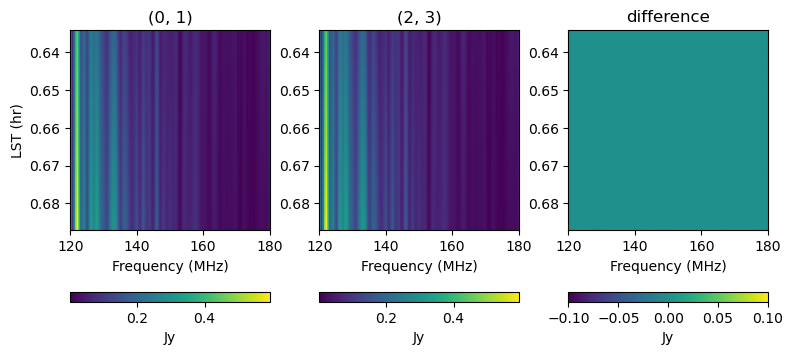

In [14]:
bls_plot = [(0, 1), (2, 3)]

lsts_hr = np.rad2deg(np.unique(uvd.lst_array)) / 15
freqs_MHz = freqs * 1e-6

fig = plt.figure(figsize=(9,4), dpi=100)
axes = fig.subplots(1,3)
for i, bl in enumerate(bls_plot):
    ax = axes[i]
    im = ax.imshow(np.abs(uvd.get_data(bl+('ee',))), aspect='auto',
                   extent=[freqs_MHz.min(), freqs_MHz.max(), lsts_hr.max(), lsts_hr.min()])
    ax.set_title(bl)
    ax.set_xlabel('Frequency (MHz)')
    if(i == 0):
        ax.set_ylabel('LST (hr)')
    cb = fig.colorbar(im, orientation='horizontal', pad=0.2)
    cb.set_label('Jy')
ax = axes[2]
im = ax.imshow(np.abs(uvd.get_data(bls_plot[0]+('ee',)))-np.abs(uvd.get_data(bls_plot[1]+('ee',))), aspect='auto',
               extent=[freqs_MHz.min(), freqs_MHz.max(), lsts_hr.max(), lsts_hr.min()])
ax.set_title('difference')
ax.set_xlabel('Frequency (MHz)')
cb = fig.colorbar(im, orientation='horizontal', pad=0.2)
cb.set_label('Jy')

fig.subplots_adjust(wspace=0.25)